# Processing of Slocum Glider-AD2CP Data: RU36 2023

jgradone@marine.rutgers.edu     03/10/2022    Initial <br>
jgradone@marine.rutgers.edu     06/16/2022    Update for pre-processing <br>
engdahl@marine.rutgers.edu      01/19/2024    Modify Notebook 2, 3 & 4 with new example using nbronikowski@mun.ca functions    
engdahl@marine.rutgers.edu      04/04/2024    Modified make_dataset to have magnetic declination function to rotate U and V dac

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data  <br>
3) Pre-process and Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
4) Save output from each segment<br>

*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
import scipy.interpolate as interp
from scipy.sparse.linalg import lsqr
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys
from datetime import datetime


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'../src/analysis/')
sys.path.insert(0,'../src/data/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform, qaqc_post_coord_transform, mag_var_correction
from analysis import get_erddap_dataset



import importlib
import NicolaiFunctions
importlib.reload(NicolaiFunctions)
from NicolaiFunctions import calcAHRS as calcAHRS_NI
from NicolaiFunctions import beam2enu as beam2enu_NI
from NicolaiFunctions import correct_ad2cp_heading
from NicolaiFunctions import inversion as inversion_NI

## Step 1: Load Glider Data

In [2]:
ds_id = 'ru36-20230525T1748-trajectory-raw-delayed'


## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)



ds_id2 = 'ru36-20230525T1748-trajectory-raw-rt'


## Load flight data, need magnetic declination to rotate depth averaged current later on
variables2 = ['time','m_gps_mag_var']
gdf2 = get_erddap_dataset(ds_id2, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables2, filetype='dataframe')
gdf2.columns = variables2


gdf=gdf.merge(gdf2,on='time',how='left')
gdf

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading,m_gps_mag_var
0,0.000000,38.026363,-63.452682,2023-05-25T17:48:02.52Z,0.0000,0.00000,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
1,0.000000,38.026363,-63.452682,2023-05-25T17:48:11.39Z,0.0000,0.00000,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2,NaN,38.026363,-63.452682,2023-05-25T17:48:12.28Z,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),0.0,0.0,6.2221,0.280998
3,NaN,38.026363,-63.452682,2023-05-25T17:48:12.39Z,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
4,NaN,38.026363,-63.452682,2023-05-25T17:48:13.39Z,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1686708,-0.071364,37.708178,-63.127247,2023-06-10T09:27:12.48Z,20.8637,5.08320,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN
1686709,-0.073349,37.708178,-63.127247,2023-06-10T09:27:13.48Z,20.8640,5.08318,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN
1686710,-0.047047,37.708178,-63.127247,2023-06-10T09:27:14.48Z,20.8659,5.08337,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN
1686711,NaN,37.708178,-63.127247,2023-06-10T09:27:15.48Z,NaN,NaN,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN


## Step 2: Load in AD2CP data frame

In [5]:
path='../Passengers/AD2CP_data_leg2/pass2_0000_netcdf_100000kb_partition_ncs_no_header/'
files = np.sort(glob.glob(path+'*.nc'))

tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## Because files are not necessarily read in time order with above line
tot_ad2cp = tot_ad2cp.sortby('time')
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange','Correlation Range':'CorrelationRange','Amplitude Range':'AmplitudeRange'})
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll'] 
# 2) Surface depth is 10 meters. Needed for at least for the 2020 and both 2021 deployments, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
# Put time on x-dimension
tot_ad2cp = tot_ad2cp.transpose()

# specific to this deployment because it was recovered 6/14 , need to subset time
tot_ad2cp=tot_ad2cp.sel(time=slice('2023-05-25', '2023-06-14'))
tot_ad2cp

C:\Users\JuliaEngdahl\miniconda3\envs\rucool\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:                    (time: 4935810, VelocityRange: 15,
                                CorrelationRange: 15, AmplitudeRange: 15,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 2023-05-25T17:48:31.0320...
  * VelocityRange              (VelocityRange) float32 2.2 4.2 6.2 ... 28.2 30.2
  * CorrelationRange           (CorrelationRange) float32 2.2 4.2 ... 28.2 30.2
  * AmplitudeRange             (AmplitudeRange) float32 2.2 4.2 ... 28.2 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/43)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(15, 199536), meta=np.ndarray>
    ...                         ...
    EnsembleCount              (time) float64 dask.array<chunksize=(199536,), meta=np.ndarray>
    WaterTemperature           (time) float32 dask.array<chunksize=(199536,), meta=np.ndarray>
    Pressure                   (time) float64 dask.array<chunksize=(199536,), meta=np.ndarray>
    Heading                    (time) float32 dask.array<chunksize=(199536,), meta=np.ndarray>
    Pitch                      (time) float32 dask.array<chunksize=(199536,), meta=np.ndarray>
    Roll                       (time) float32 dask.array<chunksize=(199536,), meta=np.ndarray>
Attributes: (12/348)
    exportRevision:                               4489
    File_ins_runTime:                             51840125.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Steps 3-10: Big loop to process velocity data and save output

In [7]:
for x in range(0,len(start_times)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
    
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    if len(ind)>0:
        ## Pull out last non-NaN lat/lon
        # ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()
#         vx          = subsetgdf.m_water_vx.iloc[ind1[-1]]
#         vy          = subsetgdf.m_water_vy.iloc[ind1[-1]]
#         vx_start_lon = subsetgdf.longitude.iloc[ind1[0]]
#         vx_start_lat = subsetgdf.latitude.iloc[ind1[0]]
#         vx_end_lon   = subsetgdf.longitude.iloc[ind1[-1]]
#         vx_end_lat   = subsetgdf.latitude.iloc[ind1[-1]]
        
        
        vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
        mag_var     = subsetgdf.m_gps_mag_var.iloc[ind[-1]]
        vx_start_lon = subsetgdf.longitude.iloc[ind[0]]
        vx_start_lat = subsetgdf.latitude.iloc[ind[0]]
        vx_end_lon   = subsetgdf.longitude.iloc[ind[-1]]
        vx_end_lat   = subsetgdf.latitude.iloc[ind[-1]]
        vx_start_tm = subsetgdf.time.iloc[0]
        vx_end_tm   = subsetgdf.time.iloc[-1]
        
    if subsetgdf.depth.max() < 10:
            continue
            
            
    ad2cp_time_ind = np.where((tot_ad2cp.time.values >= start_times2[x]) & (tot_ad2cp.time.values <= end_times2[x]))[0]
    if len(ad2cp_time_ind) > 0:

        subset_ad2cp = tot_ad2cp.sel(time= slice(tot_ad2cp.time.values[ad2cp_time_ind[0]],tot_ad2cp.time.values[ad2cp_time_ind[-1]]))

        # Just check if there is still data after the subsetting 
        if len(subset_ad2cp.time) > 0:
            
            # Pre -process data before inversion
            subset_ad2cp = correct_sound_speed(subset_ad2cp)
            subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)
            subset_ad2cp = beam_true_depth(subset_ad2cp)
            subset_ad2cp = binmap_adcp(subset_ad2cp)
            # correct heading, vx, and vy with m_gps_mag_var
            heading_cor,vx_cor,vy_cor=mag_var_correction(subset_ad2cp['Heading'].values,vx,vy,mag_var)

            if 'AHRSRotationMatrix' in tot_ad2cp.variables:
                print('AD2CP has AHRS Unit')
                subset_ad2cp = beam2enu(subset_ad2cp)

            else:
                print('AD2CP has Standard Unit')
                subset_ad2cp.attrs['beam2xyz'] = subset_ad2cp.burst_beam2xyz.reshape(4,4)
                # RotMatrix=calcAHRS_NI(subset_ad2cp['Heading'].values,subset_ad2cp['Roll'].values,subset_ad2cp['Pitch'].values)
                RotMatrix=calcAHRS_NI(heading_cor,subset_ad2cp['Roll'].values,subset_ad2cp['Pitch'].values)
                # Get your conditions
                subset_ad2cp['AHRSRotationMatrix'] = (('x','time'), RotMatrix)
                subset_ad2cp = beam2enu_NI(subset_ad2cp)

            subset_ad2cp = qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.75, surface_depth_to_filter = 5)
           
            # ## Now ready for inversion!
            dz=10
            # O_ls, G_ls, bin_new,obs_per_bin  = inversion_NI(U=subset_ad2cp.UVelocity.values,V=subset_ad2cp.VVelocity.values,dz=dz,u_daverage=vx,v_daverage=vy,bins = subset_ad2cp['VelocityRange'].values, depth = subset_ad2cp['Pressure'].values,wDAC=5, wSmoothness=1)
            
            wDAC = 5
            wSmoothness = 1
            # O_ls, G_ls, bin_new, obs_per_bin = inversion_NI(subset_ad2cp.UVelocity.values,subset_ad2cp.VVelocity.values,dz,vx,vy,subset_ad2cp['VelocityRange'].values,subset_ad2cp['Pressure'].values, wDAC, wSmoothness)
            O_ls, G_ls, bin_new, obs_per_bin = inversion_NI(subset_ad2cp.UVelocity.values,subset_ad2cp.VVelocity.values,dz,vx_cor,vy_cor,subset_ad2cp['VelocityRange'].values,subset_ad2cp['Pressure'].values, wDAC, wSmoothness)
            now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
            print("Finished Inversion", x ,"out of",len(start_times),"at" ,now)

            ###############################################
            #             Save master dataset             #
            ###############################################
            fname = "../Passengers/AD2CP_data_leg2/ad2cp_csv/RU36_2023_AD2CP_Processed_Segment_"+str(x)+".csv".format(dz,x)

            ## Make into a dataframe to save as a CSV
            d = {'inversion_u': np.real(O_ls), 'inversion_v': np.imag(O_ls), "inversion_depth": bin_new,
                 "start_lon": np.tile(vx_start_lon,len(bin_new)), "start_lat": np.tile(vx_start_lat,len(bin_new)),
                 "end_lon": np.tile(vx_end_lon,len(bin_new)), "end_lat": np.tile(vx_end_lat,len(bin_new)),
                 "start_tm": np.tile(vx_start_tm, len(bin_new)), "end_tm": np.tile(vx_end_tm, len(bin_new)),
                 "obs_per_bin": obs_per_bin}


            df = pd.DataFrame(data=d)
            df.to_csv(fname,index=False) 
            now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
            print("Finished Writing Data", x ,"out of",len(start_times),"at" ,now)
            del subset_ad2cp
            
        else:
            del subset_ad2cp
            

AD2CP has Standard Unit
(9, 3208)
Finished Inversion 0 out of 241 at 04/02/24 15:33:18
Finished Writing Data 0 out of 241 at 04/02/24 15:33:18
AD2CP has Standard Unit
(9, 9612)
Finished Inversion 1 out of 241 at 04/02/24 15:35:02
Finished Writing Data 1 out of 241 at 04/02/24 15:35:02
AD2CP has Standard Unit
(9, 18480)
Finished Inversion 3 out of 241 at 04/02/24 15:38:26
Finished Writing Data 3 out of 241 at 04/02/24 15:38:26
AD2CP has Standard Unit
(9, 24730)
Finished Inversion 5 out of 241 at 04/02/24 15:42:53
Finished Writing Data 5 out of 241 at 04/02/24 15:42:53
AD2CP has Standard Unit
(9, 32170)
Finished Inversion 7 out of 241 at 04/02/24 15:48:38
Finished Writing Data 7 out of 241 at 04/02/24 15:48:38
AD2CP has Standard Unit
(9, 32167)
Finished Inversion 9 out of 241 at 04/02/24 15:54:21
Finished Writing Data 9 out of 241 at 04/02/24 15:54:21
AD2CP has Standard Unit
(9, 40320)
Finished Inversion 10 out of 241 at 04/02/24 16:01:49
Finished Writing Data 10 out of 241 at 04/02/24 1

## Load in Processed AD2CP Data and Export NetCDF

In [8]:
path ='../Passengers/AD2CP_data_leg2/ad2cp_csv/'
fname='../Passengers/AD2CP_data_leg2/processed_nc/Passengers2_ad2cp_20230525_to_20230614_magvar.nc'
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

inversion_dz = np.diff(df.inversion_depth)[0].astype(int)
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+inversion_dz,inversion_dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="RU36 Nortek AD2CP least-squares inversion velocity profile dataset \nPassengers Project \nhttp://slocum-data.marine.rutgers.edu/erddap/tabledap/ru36-20230525T1748-trajectory-raw-delayed.html"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
#save output to netcdf
ds.to_netcdf(fname)
ds

<xarray.Dataset>
Dimensions:     (depth: 98, time: 97)
Coordinates:
  * time        (time) datetime64[ns] 2023-05-25T18:02:43.770000 ... 2023-06-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 0.5401 0.5146 0.4954 ... nan nan nan
    v_grid      (depth, time) float64 0.2273 0.1643 0.08756 ... nan nan nan
    latitude    (time) float64 38.03 38.03 38.04 38.04 ... 37.77 37.74 37.71
    longitude   (time) float64 -63.45 -63.44 -63.43 ... -62.78 -62.8 -62.83
    start_lat   (time) float64 38.03 38.03 38.03 38.04 ... 37.78 37.75 37.72
    start_lon   (time) float64 -63.45 -63.45 -63.43 ... -62.77 -62.79 -62.81
    end_lat     (time) float64 38.03 38.03 38.04 38.04 ... 37.75 37.72 37.71
    end_lon     (time) float64 -63.45 -63.43 -63.42 ... -62.79 -62.81 -62.84
    start_time  (time) datetime64[ns] 2023-05-25T17:48:02.520000 ... 2023-06-...
    end_time    (time) datetime64[ns] 2023-05-25T18:02:43.770000 ... 2023-06-...
Attributes:
    description:  RU36 Nortek AD2CP least-squares inversion velocity profile ...

In [9]:
ds = xr.open_dataset('../Passengers/AD2CP_data_leg2/processed_nc/Passengers2_ad2cp_20230525_to_20230614_magvar.nc')
ds

<xarray.Dataset>
Dimensions:     (depth: 98, time: 97)
Coordinates:
  * time        (time) datetime64[ns] 2023-05-25T18:02:43.770000 ... 2023-06-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 ...
    v_grid      (depth, time) float64 ...
    latitude    (time) float64 ...
    longitude   (time) float64 ...
    start_lat   (time) float64 ...
    start_lon   (time) float64 ...
    end_lat     (time) float64 ...
    end_lon     (time) float64 ...
    start_time  (time) datetime64[ns] ...
    end_time    (time) datetime64[ns] ...
Attributes:
    description:  RU36 Nortek AD2CP least-squares inversion velocity profile ...

In [10]:
gdf['time']=pd.to_datetime(gdf.time)
gdf=gdf.set_index('time')
gdf

,depth,latitude,longitude,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading,m_gps_mag_var
time,,,,,,,,,,
2023-05-25 17:48:02.520000+00:00,0.000000,38.026363,-63.452682,0.0000,0.00000,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 17:48:11.390000+00:00,0.000000,38.026363,-63.452682,0.0000,0.00000,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 17:48:12.280000+00:00,NaN,38.026363,-63.452682,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),0.0,0.0,6.2221,0.280998
2023-05-25 17:48:12.390000+00:00,NaN,38.026363,-63.452682,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 17:48:13.390000+00:00,NaN,38.026363,-63.452682,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-06-10 09:27:12.480000+00:00,-0.071364,37.708178,-63.127247,20.8637,5.08320,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN
2023-06-10 09:27:13.480000+00:00,-0.073349,37.708178,-63.127247,20.8640,5.08318,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN
2023-06-10 09:27:14.480000+00:00,-0.047047,37.708178,-63.127247,20.8659,5.08337,ru36-2023-158-0-9-dbd(01240009),NaN,NaN,NaN,NaN


In [11]:
sub_gdf=gdf['2023-05-25 18':'2023-06-07 20']
sub_gdf

,depth,latitude,longitude,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading,m_gps_mag_var
time,,,,,,,,,,
2023-05-25 18:00:00+00:00,26.855028,38.028740,-63.447953,22.2352,5.20980,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 18:00:00.020000+00:00,NaN,38.028740,-63.447953,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,5.39656,NaN
2023-05-25 18:00:01+00:00,NaN,38.028743,-63.447951,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 18:00:02+00:00,26.332832,38.028746,-63.447949,22.2382,5.20989,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
2023-05-25 18:00:03+00:00,NaN,38.028749,-63.447947,NaN,NaN,ru36-2023-144-1-0-dbd(01180000),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-06-01 21:35:38.750000+00:00,NaN,37.773705,-62.968705,NaN,NaN,ru36-2023-150-0-9-dbd(01230009),NaN,NaN,NaN,NaN
2023-06-01 21:35:38.780000+00:00,0.067493,37.773705,-62.968705,22.2159,5.22027,ru36-2023-150-0-9-dbd(01230009),NaN,NaN,NaN,NaN
2023-06-01 21:35:39.780000+00:00,0.054590,37.773705,-62.968705,22.2153,5.22001,ru36-2023-150-0-9-dbd(01230009),NaN,NaN,NaN,NaN


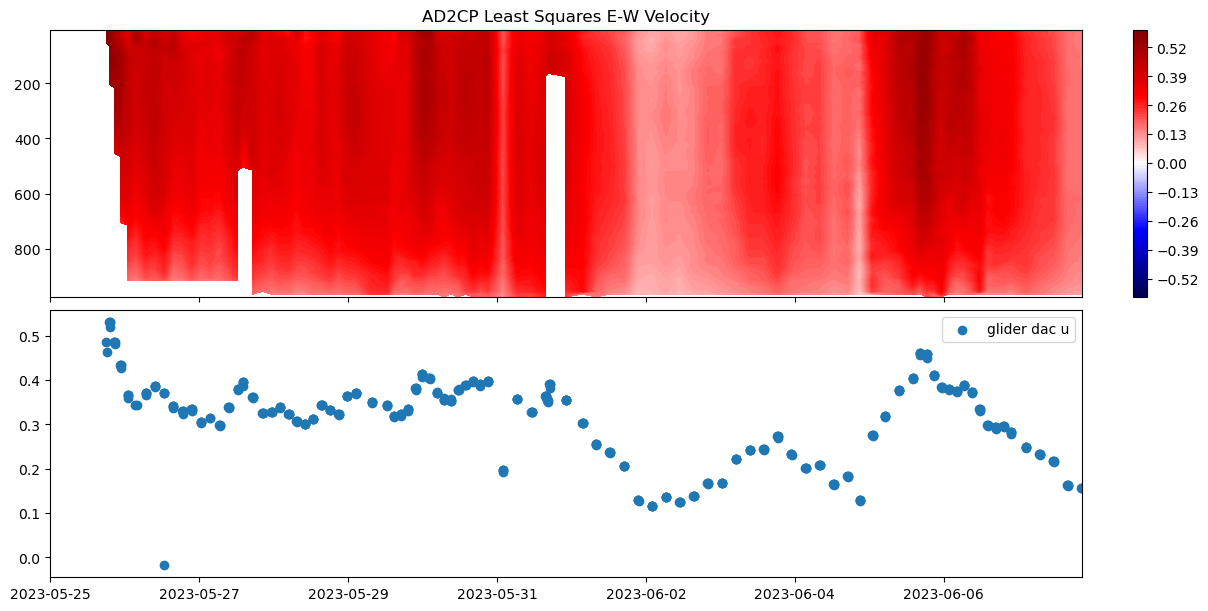

In [13]:
fig,ax=plt.subplots(2,1,figsize=(12,6),sharex=True,constrained_layout=True)

a=ax[0].contourf(ds.time.values,ds.depth.values,ds.u_grid.values,cmap='seismic',levels=np.arange(-0.6,0.61,0.01))
ax[0].invert_yaxis()
ax[0].set_title('AD2CP Least Squares E-W Velocity')
plt.colorbar(a,ax=ax[0])



m_vx = sub_gdf.m_water_vx.values*np.cos(sub_gdf.m_gps_mag_var.values) + sub_gdf.m_water_vy.values*np.sin(sub_gdf.m_gps_mag_var.values)

# plt.xticks(rotation=30)

ax[1].scatter(sub_gdf.index,m_vx,label='glider dac u')
ax[1].legend()

xticks = pd.date_range('2023-05-25 ','2023-06-07 ',freq='2D')
ax[1].set_xticks(xticks)
# ax[1].set_xticklabels(xticks)

plt.savefig('./figures/ad2cp_lsq_U_magvar.png')

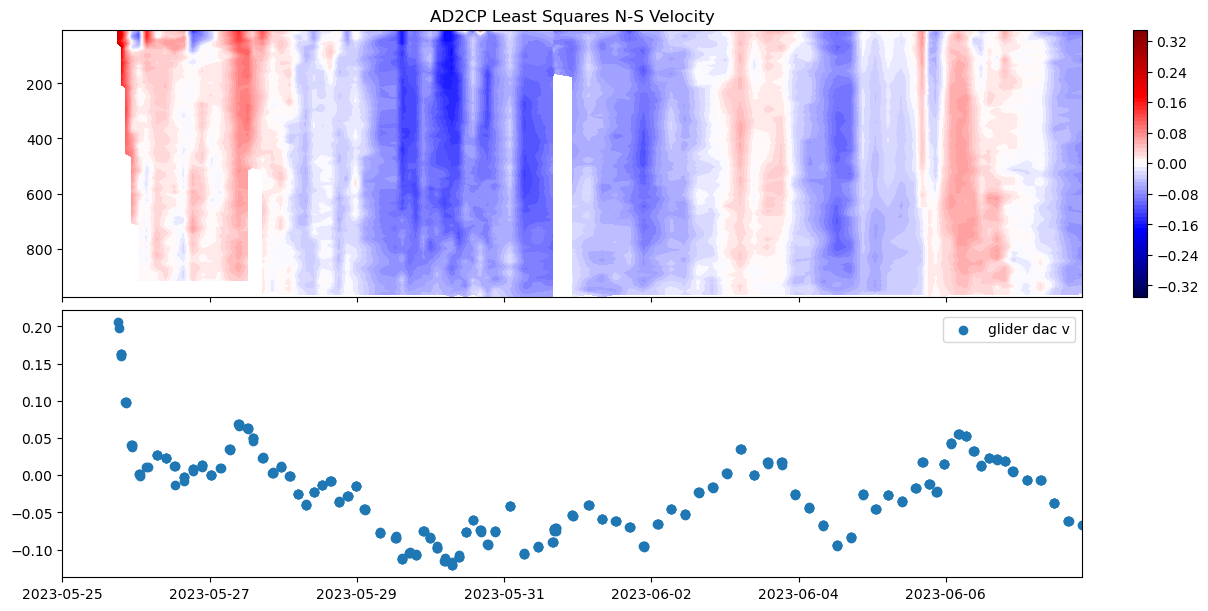

In [15]:
fig,ax=plt.subplots(2,1,figsize=(12,6),sharex=True,constrained_layout=True)

a=ax[0].contourf(ds.time.values,ds.depth.values,ds.v_grid.values,cmap='seismic',levels=np.arange(-0.35,0.36,0.01))
ax[0].invert_yaxis()
ax[0].set_title('AD2CP Least Squares N-S Velocity')
plt.colorbar(a,ax=ax[0])
m_vy = sub_gdf.m_water_vx.values*np.sin(sub_gdf.m_gps_mag_var.values) + sub_gdf.m_water_vy.values*np.cos(sub_gdf.m_gps_mag_var.values)
# plt.xticks(rotation=30)

ax[1].scatter(sub_gdf.index,m_vy,label='glider dac v')
ax[1].legend()

xticks = pd.date_range('2023-05-25 ','2023-06-07 ',freq='2D')
ax[1].set_xticks(xticks)
plt.savefig('./figures/ad2cp_lsq_V_magvar.png')